<h1><p><strong>Where did you get the data ?</strong> <strong></strong></p></h1>

In [1]:
%%html
<table cellspacing='2'>
<td> <a href="https://www.kaggle.com/kmader/electron-microscopy-3d-segmentation/home">link to kaggle dataset</a> <p>&nbsp;</p></td>
    <tr>   
    <td> <img src="./kaggledata.jpg" alt="image" style="width: 1000px;"/> </td>
    </tr>
</table>

""


------------------------------------------------------------------------------------------------------------------------------

<h1><p><strong> Show me an example of an image and it's corresponding label</strong> <strong><em>(=mask)</em></strong>.</p></h1>

In [2]:
%%html
    <tr>
    <td> <img src="./images/img0.jpg" alt="image" style="width: 300px;"/> </td>
    <td> <img src="./masks/img0.jpg" alt="mask" style="width: 300px;"/> </td>
    </tr>

,


------------------------------------------------------------------------------------------------------------------------------

<h1><p><strong> Question : How did one make the label(=mask) again ? </strong> <strong><em></em></strong></p></h1>

In [3]:
%%html
<table cellspacing='2'>
<td> <a href="http://www.robots.ox.ac.uk/~vgg/software/via/via-1.0.6.html">annotate the image link</a> <p>&nbsp;</p></td>
    <tr>   
    <td> <img src="./make_annotate.jpg" alt="image" style="width: 800px;"/> </td>
    </tr>
</table>

""


--------------------------------------------------------------------------------------------------------------------------------

<h1><p><strong>  Let's start building a model that can do the task</strong></p></h1><h2><strong><em>=>learn the label(=mask) with respect to the given image for segmentation </em></strong></h2>

## Step 1. Load dataset 

In [1]:
# to install Conx package go to https://github.com/Calysto/conx
# https://github.com/Calysto/conx-notebooks/tree/master/HowToRun#how-to-run-conx
# exercise for all deep learning : https://github.com/Calysto/conx-notebooks
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
tile_size = (64, 64)

In [2]:
# dataset from :https://www.kaggle.com/kmader/electron-microscopy-3d-segmentation
train_em_image_vol = imread('./training.tif')[:40, ::2, ::2]
train_em_seg_vol = imread('./training_groundtruth.tif')[:40, ::2, ::2]>0
#test_em_image_vol = imread('./training.tif')[:40, ::2, ::2]
#test_em_seg_vol = imread('./training_groundtruth.tif')[:40, ::2, ::2]>0
#print("Data Loaded, Dimensions", train_em_image_vol.shape,'->',train_em_seg_vol.shape)
def g_random_tile(em_image_vol, em_seg_vol):
    z_dim, x_dim, y_dim = em_image_vol.shape
    z_pos = np.random.choice(range(z_dim))
    x_pos = np.random.choice(range(x_dim-tile_size[0]))
    y_pos = np.random.choice(range(y_dim-tile_size[1]))
    return np.expand_dims(em_image_vol[z_pos, x_pos:(x_pos+tile_size[0]), y_pos:(y_pos+tile_size[1])],-1), \
            np.expand_dims(em_seg_vol[z_pos, x_pos:(x_pos+tile_size[0]), y_pos:(y_pos+tile_size[1])],-1).astype(float)
np.random.seed(2018)
t_x, t_y = g_random_tile(train_em_image_vol, train_em_seg_vol)
print('x:', t_x.shape, 'Range:', t_x.min(), '-', t_x.max())
print('y:', t_y.shape, 'Range:', t_y.min(), '-', t_y.max())
train_em_image_vol.shape, train_em_seg_vol.shape

x: (64, 64, 1) Range: 65 - 193
y: (64, 64, 1) Range: 0.0 - 1.0


((40, 384, 512), (40, 384, 512))

## Step 2.1 Exploration - visualize randomly chosen images and labels(=masks)
### notice there are positive as well as negative samples

------------- positive image + mask = one or more masks-------------


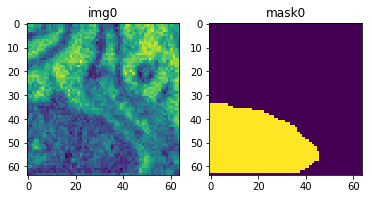

------------- positive image + mask = one or more masks-------------


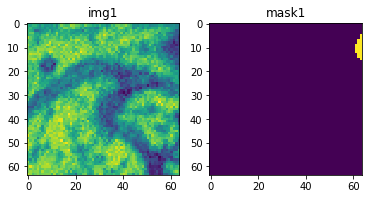

------------- positive image + mask = one or more masks-------------


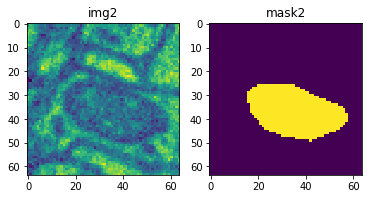

------------- positive image + mask = one or more masks-------------


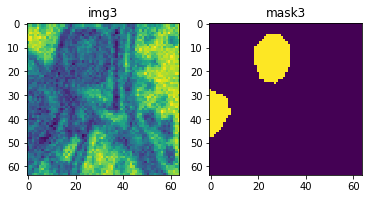

-------------negative image + mask= no mask exists -------------


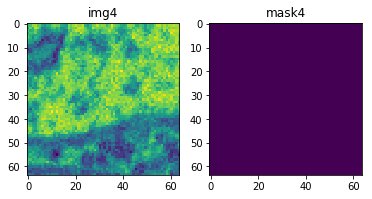

In [8]:

# when need to produce images as well as the mask for markRCNN model
%matplotlib inline
import pandas as pd
#df=pd.DataFrame(columns=['img_id','label'])
num_imgs=5
track=0
#labels=[]
#img_ids=[]
for i in range(num_imgs):
    im_x,im_y=g_random_tile(train_em_image_vol, train_em_seg_vol)
    if len(np.unique(im_y))>1 and track<=num_imgs:
        print("------------- positive image + mask = one or more masks-------------")
        f = plt.figure()
        f.add_subplot(1,2, 1)
        plt.imshow(im_x.squeeze())
        plt.title("img"+str(track))
        #plt.imsave('./hackthon/images/img{}.jpg'.format(str(track)),im_x.squeeze())
        #img_ids.append("img"+str(track))
        #labels.append('1')
        f.add_subplot(1,2, 2)
        plt.imshow(im_y.squeeze())
        plt.title("mask"+str(track))
        #plt.imsave('./hackthon/masks/img{}.jpg'.format(str(track)),im_y.squeeze())
        #print(np.max(im_y), np.min(im_y))
        #print(np.unique(im_y, return_counts=True), len(np.unique(im_y)))
        plt.show(block=True)

    else:
        print("-------------negative image + mask= no mask exists -------------")
        f = plt.figure()
        f.add_subplot(1,2, 1)
        plt.imshow(im_x.squeeze())
        plt.title("img"+str(track))
        #plt.imsave('./hackthon/images/img{}.jpg'.format(str(track)),im_x.squeeze())
        #img_ids.append("img"+str(track))
        #labels.append('0')
        f.add_subplot(1,2, 2)
        plt.imshow(im_y.squeeze())
        plt.title("mask"+str(track))
        #plt.imsave('./hackthon/masks/img{}.jpg'.format(str(track)),im_y.squeeze())
        #print(np.max(im_y), np.min(im_y))
        #print(np.unique(im_y, return_counts=True), len(np.unique(im_y)))
        plt.show(block=True)
    track+=1

#print(len(labels), len(img_ids))


In [7]:
ip_pairs = [g_random_tile(train_em_image_vol, train_em_seg_vol) for _ in range(100)]
ip_pairs[0][0].shape, ip_pairs[0][1].shape

((64, 64, 1), (64, 64, 1))

## Step 2.2 Exploration - understanding features 

---------------- manipulate the image morphology -------------


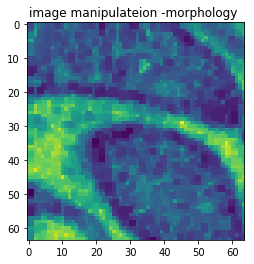

------------ find dominate color within the image ------------ 
color range start :0 end : 39.9169921875 
color range start :39.9169921875 end : 127.1484375 
color range start :127.1484375 end : 300.0 


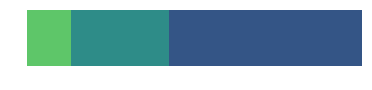

------------------------  color manipulation filter red, green , blue channels ------------------ 
(64, 64, 3)


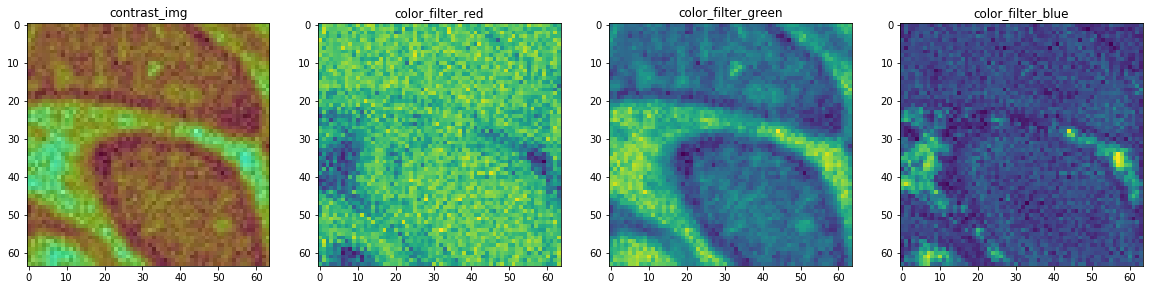

----------------- image manipulation - find contours within the image -----------------


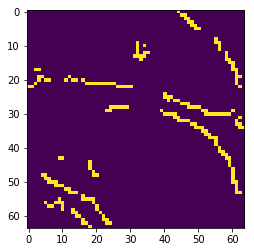

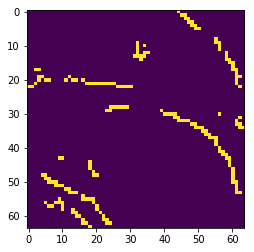

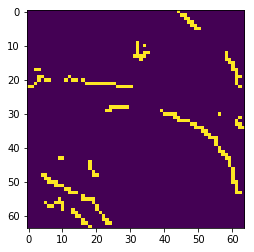

In [8]:
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
import findcolor
%matplotlib inline

sample_img=random.choice([x[0] for x in ip_pairs])
"""
#print(sample_img.shape)
# Creating our 3 x 3 kernel
kernel_3x3 = np.ones((3, 3), np.float32) / 9

# We use the cv2.fitler2D to conovlve the kernal with an image 
blurred = cv2.filter2D(sample_img, -1, kernel_3x3)
#cv2.imshow('3x3 Kernel Blurring', blurred)
#cv2.waitKey(0)
#print(blurred.shape)
print("----------------- blur the image ----------------- ")
plt.imshow(blurred)
plt.title("image manipulation - blurred")
plt.show()

print("----------------- rotate and shrink the image ----------------- ")
### rotate image
height, width = sample_img.shape[:2]
# Divide by two to rototate the image around its centre
rotation_matrix = cv2.getRotationMatrix2D((width/2, height/2), 30, .5)
rotated_image = cv2.warpAffine(sample_img, rotation_matrix, (width, height))
plt.imshow(rotated_image)
plt.title("image manipulation - rotate&shrink")
plt.show()
"""
print ("---------------- manipulate the image morphology -------------")

kernel = np.ones((2,2), np.uint8)
"""
# Now we erode
erosion = cv2.erode(sample_img, kernel, iterations = 1)
plt.imshow(erosion)
plt.title("image manipulateion -erosion")
plt.show()

dilation = cv2.dilate(sample_img, kernel, iterations = 1)
plt.imshow(dilation)
plt.title("image manipulateion -dilation")
plt.show()
"""
closing = cv2.morphologyEx(sample_img, cv2.MORPH_CLOSE, kernel)
plt.imshow(closing)
plt.title("image manipulateion -morphology ")
plt.show()


plt.imsave('colors.jpg', np.squeeze(sample_img))
## find top 3 dominant color in a given image
print("------------ find dominate color within the image ------------ ")
findcolor.find_color('colors.jpg')

im=cv2.imread('colors.jpg')
#print(im.shape)
im=im[:,:,2]

#plt.imshow(im)
#plt.show()
print("------------------------  color manipulation filter red, green , blue channels ------------------ ")
#### # Set global parameters
RED = 0
GREEN = 1
BLUE = 2

# Load the image
img_color = cv2.imread("colors.jpg", flags=cv2.IMREAD_COLOR)
print(img_color.shape)
# Filter the image by desired color
img_red = np.asarray([y[RED] for x in img_color for y in x]).reshape((img_color.shape[:2]))
img_green= np.asarray([y[GREEN] for x in img_color for y in x]).reshape((img_color.shape[:2]))
img_blue= np.asarray([y[BLUE] for x in img_color for y in x]).reshape((img_color.shape[:2]))
f = plt.figure(figsize=(20,20))
f.add_subplot(1,4, 1)
plt.imshow(img_color)
plt.title("contrast_img")
f.add_subplot(1,4, 2)
plt.imshow(img_red)
plt.title("color_filter_red")
f.add_subplot(1,4, 3)
plt.imshow(img_green)
plt.title("color_filter_green")
f.add_subplot(1,4,4 )
plt.imshow(img_blue)
plt.title("color_filter_blue")
plt.show()

# Find Canny edges
edged = cv2.Canny(np.squeeze(sample_img), 197, 255)
#print(edged.shape)
img, contours, _ = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# Sort contours smallest to largest using reverse=False
sorted_contours = sorted(contours, key=cv2.contourArea, reverse=False) 
print("----------------- image manipulation - find contours within the image -----------------")
for c in [contours[3], contours[int(len(contours)/2)], contours[-2]]:
    cv2.drawContours(img, c, -1, (0,255,0), 3)
    plt.imshow(img)
    plt.show()


## Step 3. Choose a model Architecture -> Unet

In [9]:
#build the model
import conx as cx
net = cx.Network("MiniUNet")
base_depth = 8

Using TensorFlow backend.
ConX, version 3.7.4


In [10]:
net.add(cx.ImageLayer("input", tile_size, t_x.shape[-1])) 
net.add(cx.BatchNormalizationLayer("bnorm"))
c2 = lambda i, j, act = "relu": cx.Conv2DLayer("conv_{}".format(i, j), j, (3, 3), padding='same', activation=act)
net.add(c2(0, base_depth))
net.add(c2(1, base_depth))
net.add(cx.MaxPool2DLayer("pool1", pool_size=(2, 2), dropout=0.25))
net.add(c2(2, 2*base_depth))
net.add(c2(3, 2*base_depth))
net.add(cx.MaxPool2DLayer("pool2", pool_size=(2, 2), dropout=0.25))
net.add(c2(4, 4*base_depth))
net.add(c2(5, 4*base_depth))
net.add(cx.UpSampling2DLayer("up2", size = (2,2)))
net.add(cx.ConcatenateLayer("cat2"))
net.add(c2(6, 2*base_depth))
net.add(c2(7, 2*base_depth))
net.add(cx.UpSampling2DLayer("up1", size = (2,2)))
net.add(cx.ConcatenateLayer("cat1"))
net.add(c2(8, 2*base_depth))
net.add(cx.Conv2DLayer("output", 1, (1, 1), padding='same', activation='sigmoid'));

In [11]:

net.connect('input', 'bnorm')
net.connect('bnorm', 'conv_0')
net.connect('bnorm', 'cat1')
net.connect('conv_0', 'conv_1')

In [12]:
net.connect('conv_1', 'pool1')
net.connect('pool1', 'conv_2')
net.connect('conv_2', 'conv_3')
net.connect('conv_3', 'pool2')
net.connect('pool2', 'conv_4')
net.connect('conv_4', 'conv_5')
net.connect('conv_5', 'up2')
net.connect('up2', 'cat2')
net.connect('conv_3', 'cat2')
net.connect('cat2', 'conv_6')
net.connect('conv_6', 'conv_7')
net.connect('conv_7', 'up1')
net.connect('up1', 'cat1')
net.connect('cat1', 'conv_8')
net.connect('conv_8', 'output')

In [13]:
net.compile(error="binary_crossentropy", optimizer="adam")

         but not using the 'softmax' activation function on layer 'output'


<IPython.core.display.Javascript object>


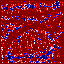
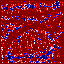
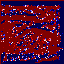
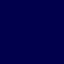
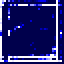
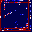
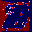
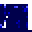
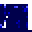
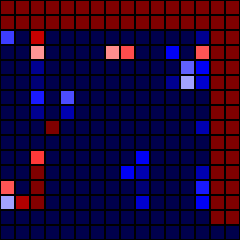
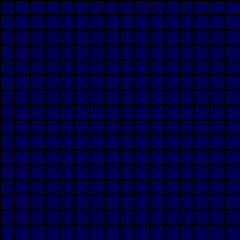
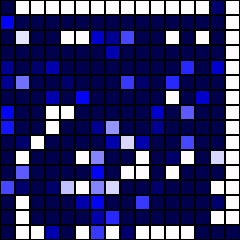
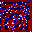
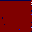
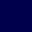
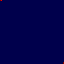
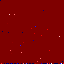
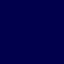
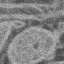

In [14]:
net.picture(t_x, dynamic = True, rotate = True, show_targets = True, scale = 1.25)

In [15]:
net.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
bnorm (BatchNormalization)      (None, 64, 64, 1)    4           input[0][0]                      
__________________________________________________________________________________________________
conv_0 (Conv2D)                 (None, 64, 64, 8)    80          bnorm[0][0]                      
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 64, 64, 8)    584         conv_0[0][0]                     
__________________________________________________________________________________________________
pool1 (Max

## Step 4. Split dataset into Train vs Validation sets to train and evaluate the model respectively. 

In [16]:

net.dataset.clear()
#ip_pairs = [g_random_tile(train_em_image_vol, train_em_seg_vol) for _ in range(200)]

net.dataset.append(ip_pairs)
net.dataset.split(0.25)

## Step 5. Evaluate the model result

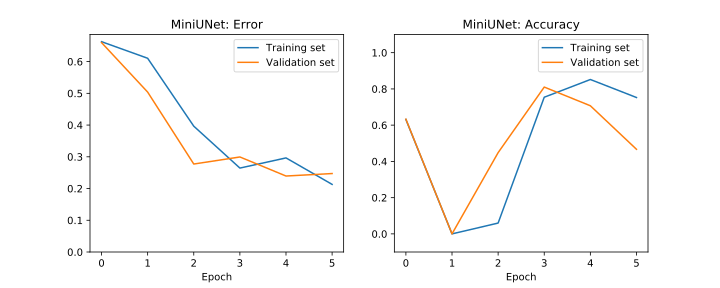

       |  Training |  Training |  Validate |  Validate 
Epochs |     Error |  Accuracy |     Error |  Accuracy 
------ | --------- | --------- | --------- | --------- 
#    5 |   0.21300 |   0.75257 |   0.24723 |   0.46682 


In [17]:

net.train(epochs=5, record=True)

In [18]:
#net.propagate_to_image("conv_5", t_x)


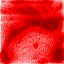
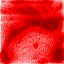
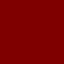
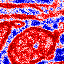
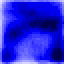
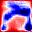
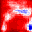
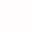
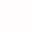
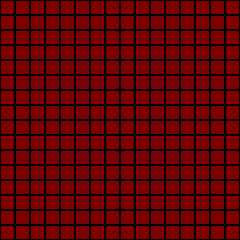
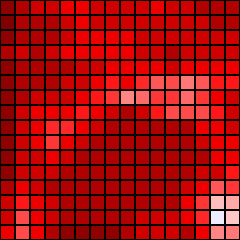
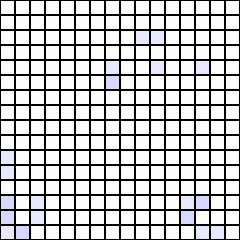
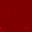
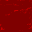
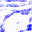
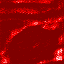
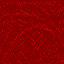
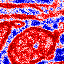
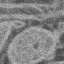

In [19]:
net.picture(t_x, dynamic = True, rotate = True, show_targets = True, scale = 1.25)

In [20]:
net.dashboard()

Dashboard(children=(Accordion(children=(HBox(children=(VBox(children=(Select(description='Dataset:', index=1, …

## (option) evaluate the result visually 

In [21]:
#net.movie(lambda net, epoch: net.propagate_to_image("conv_5", t_x, scale = 3),  'mid_conv.gif', mp4 = False)

In [22]:
net.movie(lambda net, epoch: net.propagate_to_image("conv_8", t_x, scale = 3), 
                'hr_conv.gif', mp4 = False)

In [23]:
net.movie(lambda net, epoch: net.propagate_to_image("output", t_x, scale = 3), 
                'output.gif', mp4 = False)

-------------------------------------------------------------------------------------------------------------------------------

<h1><p><strong>How to take this model to production </strong></p></h1><h2> <strong>Azure databrick architecture</strong></h2>

In [26]:
%%html
<table cellspacing='2'>
    <tr>
    <td><a href="https://notebooks.azure.com/"></a> </td>
    <td><a href="https://notebooks.azure.com/DaveVoyles/libraries/TensorFlow-Examples"></a></td>
    <td> <img src="./azure_databrick.jpg" alt="image" style="width: 1200px;"/> </td>
    </tr>
</table>

,
